In [1]:
import pickle
import random
import numpy as np
import cupy as cp
from unicode_info.database import generate_supported_consortium_feature_vectors_and_clusters_dict

In [2]:
unicode_codepoint_vectors_dict = pickle.load(open('features_dict_file.pkl', 'rb'))
unicode_index_codepoint_map = list(unicode_codepoint_vectors_dict.keys())
del unicode_codepoint_vectors_dict

unknown_codepoints_simvec_map = pickle.load(open('simmap_pointninethreshold.pkl', 'rb'))
mat = np.stack([vec for vec in unknown_codepoints_simvec_map.values()])
unknown_indices_to_codepoint = [codepoint for codepoint in unknown_codepoints_simvec_map.keys()]

In [32]:
# directly finding homoglyph codepoint sets will blow up memory
def filter_simvec_map_into_row_indices(sim_mat:np.ndarray, threshold:float):
    print(sim_mat.shape)
    arr = cp.asnumpy(cp.nonzero(cp.sum(cp.array(sim_mat) > threshold, axis=1)>1)[0])
    #arr = np.nonzero(np.count_nonzero(sim_mat > threshold, axis=1)>1)[0]
    print(arr.shape)
    return set(arr)

# these aren't equivalence classes - might be overlapping sets
def randomly_select_indices_and_find_homoglyphs_sets(sim_mat:np.ndarray, simmat_row_indices:set, threshold:float, num_sets:int, full_index_codepoint_map:list):
    pairs_for_index = {}
    sample = random.sample(simmat_row_indices, k=num_sets)
    for row_index in sample:
        homoglyph_indices = np.nonzero(sim_mat[row_index] > threshold)[0]
        if len(homoglyph_indices) > 1:
            pairs_for_index[row_index] = {full_index_codepoint_map[index] for index in homoglyph_indices}
    return pairs_for_index

In [38]:
import matplotlib.pyplot as plt
from IPython.display import display
import os
from generate_datasets import try_draw_single_font

min_supported_fonts_dict = pickle.load(open('min_supported_fonts.pkl', 'rb'))
model_info_file = open(os.path.join('model_1', 'model_info.pkl'), 'rb')
model_info_dict = pickle.load(model_info_file)
img_size, font_size = model_info_dict['img_size'], model_info_dict['font_size']
empty_image = np.full((img_size, img_size), 255)


def display_random_findings(threshold, num_set):
    str_to_u = lambda s: "U+" + hex(int(s))[2:] + ", " + s
    row_indices = filter_simvec_map_into_row_indices(mat, threshold)
    pairs_for_index = randomly_select_indices_and_find_homoglyphs_sets(mat, row_indices, threshold, num_set, unicode_index_codepoint_map)
    display("Number of unknown homoglyphs: " + str(len(row_indices)))
    display("Number of displayed sets: " + str(len(pairs_for_index))+"/" + str(num_set))
    i = 1
    for index, homoglyphs in pairs_for_index.items():
        display("=========================")
        display("=========================")
        display("Homoglyphs for Codepoint " + str_to_u(unknown_indices_to_codepoint[index]) + ", size: " + str(len(homoglyphs)) + ", #: " + str(i))
        i += 1
        for homoglyph in homoglyphs:
            image = try_draw_single_font(int(homoglyph), min_supported_fonts_dict[homoglyph], empty_image, img_size,
                                         font_size, "./fonts", transform_img=False)
            fig, ax = plt.subplots(figsize=(3,2))
            ax.imshow(image)
            display(fig)
            display(str_to_u(homoglyph))

(19906, 116294)
(8452,)


'Number of unknown homoglyphs: 8452'

'Number of displayed sets: 4/4'

'========================='

'========================='

'Homoglyphs for Codepoint U+744b, 29771, size: 2, #: 1'

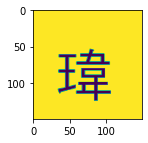

'U+744b, 29771'

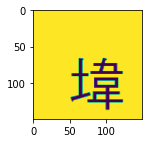

'U+3654, 13908'

'========================='

'========================='

'Homoglyphs for Codepoint U+d678, 54904, size: 2, #: 2'

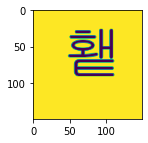

'U+d689, 54921'

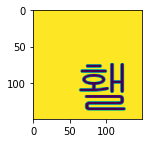

'U+d678, 54904'

'========================='

'========================='

'Homoglyphs for Codepoint U+2dd0, 11728, size: 2, #: 3'

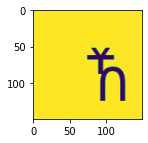

'U+2dd0, 11728'

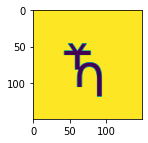

'U+2dd3, 11731'

'========================='

'========================='

'Homoglyphs for Codepoint U+fc4b, 64587, size: 3, #: 4'

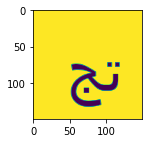

'U+fc0b, 64523'

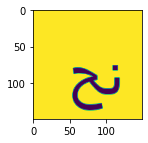

'U+fc4c, 64588'

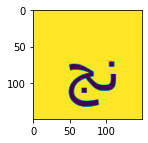

'U+fc4b, 64587'

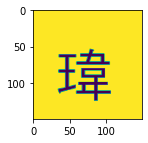

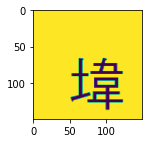

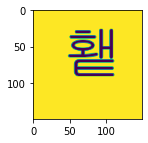

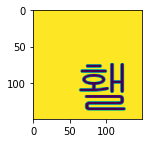

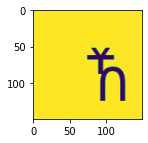

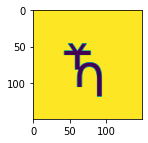

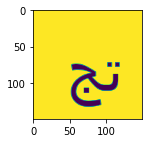

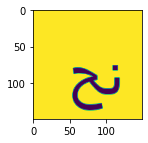

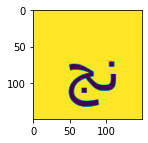

In [46]:
display_random_findings(0.93, 4)

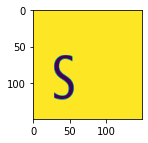

'U+a683, 42627'

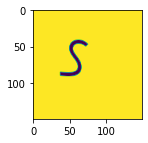

'U+1ce7, 7399'

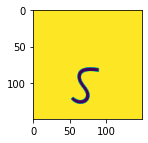

'U+1ce8, 7400'

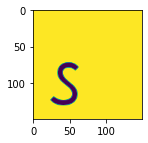

'U+10496, 66710'

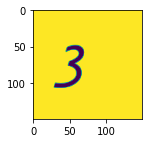

'U+109af, 68015'

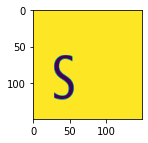

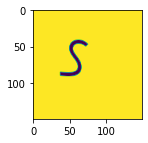

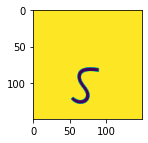

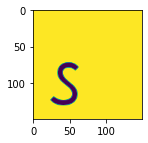

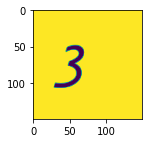

In [51]:
str_to_u = lambda s: "U+" + hex(int(s))[2:] + ", " + s
vec = unknown_codepoints_simvec_map['66710']
codes = [unicode_index_codepoint_map[index] for index in np.nonzero(vec > 0.93)[0]]
for homoglyph in codes:
    image = try_draw_single_font(int(homoglyph), min_supported_fonts_dict[homoglyph], empty_image, img_size,
                                 font_size, "./fonts", transform_img=False)
    fig, ax = plt.subplots(figsize=(3,2))
    ax.imshow(image)
    display(fig)
    display(str_to_u(homoglyph))

In [6]:
# debugging purpose
# i = 18816
# print(list(unknown_codepoints_simvec_map.items())[i])
# print([unicode_index_codepoint_map[ind] for ind in np.nonzero(mat[i] > 0.92)[0]])